# Predict 2016 Colorado voter turnout

Welcome to the Spring 2017, Harvard Statistics 149 prediction contest/course project!

**Prediction contest ends April 30, 2017, at 10pm EDT**

The goal of this project is to use the modeling methods you learned in Statistics 149 (and possibly other related methods) to analyze a data set on whether a Colorado voting-eligible citizen ended up actually voting in the 2016 US election. These data were kindly provided by moveon.org. More details can be found [here](https://inclass.kaggle.com/c/who-voted).

## Imputation of missing values

The goal of this notebook is to perform imputation of missing data as we learned in class. We will test k-Nearest Neighbor (kNN) and Multiple Imputation by Chained Equations (MICE) on the distance features in both the train and test sets. This is the third notebook for this competition. For initial exploration of the data see [part 1](who-voted_EDA.ipynb) and [part 2](who-voted_features.ipynb).

In [1]:
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Load [local functions](https://github.com/yuwie10/who-voted/blob/master/who_voted_functions.py) for this project.

In [2]:
import who_voted_functions as wv
import importlib as imp
imp.reload(wv);

In [3]:
train = wv.load_data('train_renamed.csv')
train.drop('voted', axis = 1, inplace = True)
train.head()

,gender,congress_district,state_house,age,dist_ballot,dist_poll,party,race,hs_only,married,children,cath,evang,non_chrst,other_chrst,days_reg
0,M,7.0,31.0,36,NaN,NaN,U,Hispanic,25.4,63.4,54.0,16.7,16.5,39.6,27.3,420
1,F,6.0,38.0,55,NaN,NaN,U,Uncoded,7.9,97.8,59.8,16.7,15.5,30.9,36.9,307
2,F,2.0,53.0,24,NaN,NaN,U,Caucasian,50.2,7.6,49.5,14.6,24.0,29.6,31.7,292
3,F,7.0,30.0,25,NaN,NaN,D,Caucasian,38.0,8.5,47.4,13.1,22.3,33.3,31.4,316
4,M,5.0,19.0,22,NaN,NaN,R,Caucasian,30.5,19.1,23.1,16.0,10.5,39.1,34.5,392


In [4]:
test = wv.load_data('test.csv', str1 = 'cd', str2 = 'sh')
id_col = test['Id']
test.drop('Id', axis = 1, inplace = True)
test.columns = train.columns.tolist()
test.head()

,gender,congress_district,state_house,age,dist_ballot,dist_poll,party,race,hs_only,married,children,cath,evang,non_chrst,other_chrst,days_reg
0,M,2,52.0,30,NaN,NaN,L,Caucasian,19.5,21.2,25.3,9.8,16.6,45.2,28.4,393
1,F,5,19.0,20,NaN,NaN,U,Caucasian,39.7,20.2,29.1,12.0,14.4,41.4,32.2,668
2,M,4,44.0,56,NaN,NaN,R,Caucasian,11.3,62.7,41.3,14.8,14.7,36.0,34.6,606
3,F,7,34.0,20,NaN,NaN,R,Caucasian,32.8,11.6,33.1,14.5,10.3,44.6,30.6,565
4,F,6,41.0,26,NaN,NaN,D,Uncoded,10.2,14.7,22.4,8.2,18.4,43.5,29.9,336


In [5]:
train.shape
test.shape
test.info()

(118529, 16)

(39510, 16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39510 entries, 0 to 39509
Data columns (total 16 columns):
gender               39510 non-null object
congress_district    39509 non-null object
state_house          39509 non-null float64
age                  39510 non-null int64
dist_ballot          1752 non-null float64
dist_poll            1752 non-null float64
party                39510 non-null object
race                 39510 non-null object
hs_only              39510 non-null float64
married              39510 non-null float64
children             39510 non-null float64
cath                 39510 non-null float64
evang                39510 non-null float64
non_chrst            39510 non-null float64
other_chrst          39510 non-null float64
days_reg             39510 non-null int64
dtypes: float64(10), int64(2), object(4)
memory usage: 4.8+ MB


In [6]:
combined = train.append(test)
combined.shape

(158039, 16)

Let's investigate the distance predictors we are going to impute.

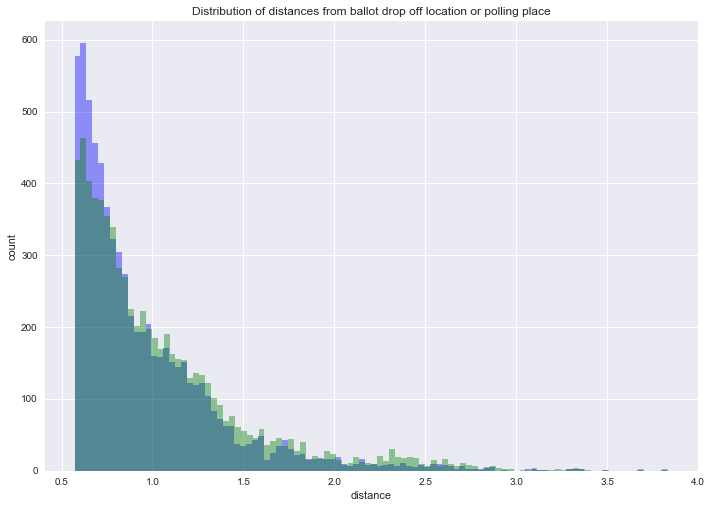

In [7]:
no_nulls = combined.dropna()
distances = ['dist_ballot', 'dist_poll']
colors = ['blue', 'green']

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27);

for dist, color in zip(distances, colors):
    p = sns.distplot(np.log(no_nulls[dist]),
                     color = color,
                     kde = False, bins = 100);
    _ = p.set_xlabel('distance');
    _ = p.set_ylabel('count');
    _ = p.set_title('Distribution of distances from ballot drop off location or polling place');

Because the two variables are similar, we can test imputation on just one of the two distance variables. Let's pick dist_poll and use this column as our response variable for kNN regression.

In [13]:
y = no_nulls['dist_poll'].as_matrix()
y

array([ 9.2502 ,  4.28483,  1.99877, ...,  2.0558 ,  1.82069,  2.40694])

For our design matrix we want to 'train' on all columns except the distance predictors.

In [14]:
quantitative = ['age', 'hs_only', 'married', 'children', 'cath',
                'evang', 'non_chrst', 'other_chrst', 'days_reg']
categorical = ['gender', 'congress_district', 'state_house', 'party', 'race']

X = wv.design_Xmatrix(no_nulls, quantitative, categorical, standardize = True)
X

array([[-0.58256449, -1.11572631, -0.21804297, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.52783299,  0.22213267,  0.57435185, ...,  0.        ,
         0.        ,  0.        ],
       [-0.45192949, -0.58921407,  1.17312983, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 1.05037298, -0.2008034 , -0.90645837, ...,  0.        ,
         0.        ,  0.        ],
       [-0.0600245 , -0.59784541,  0.0544548 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.69296197,  2.86332523, -1.81000359, ...,  0.        ,
         0.        ,  0.        ]])

We will pick a cross-validation split of 10.

In [11]:
cv = KFold(n_splits=10)

[SigOpt](sigopt.com) provides an API that uses Bayesian optimization to tune hyperparameters. We can set up a SigOpt experiment to evaluate the best number of nearest neighbors.

In [13]:
from sigopt import Connection
conn = Connection(client_token = 'ZGILQJTPPAWFCOOOZPALZQHRKNBANVQQUEVEJJSYYOUVYNYI')

In [14]:
#create SigOpt experiment
experiment = conn.experiments().create(
  name='who voted: kNN imputation',
  parameters=[
    dict(name='n_neighbors', type='int', bounds=dict(min=3, max=100))
  ]
)
print('Created experiment: https://sigopt.com/experiment/' + experiment.id)

Created experiment: https://sigopt.com/experiment/17663


In [15]:
def evaluate_model(assignments, X, y, cv, weights):
    '''
    Evaluates different kNN regression model with different number of nearest neighbors.
    
    Inputs:
    assignments = suggested parameters from SigOpt
    X and y matrices
    cv = cross-validation scheme
    
    Returns: mean and std of cv accuracies
    '''
    model = KNeighborsRegressor(n_neighbors=assignments['n_neighbors'],
                                metric = 'hamming',
                                weights = weights)
    cv_accuracies = cross_val_score(model, X, y, cv=cv)
    return (np.mean(cv_accuracies), np.std(cv_accuracies))

In [16]:
for _ in range(20):
    # Receive a Suggestion from SigOpt
    suggestion = conn.experiments(experiment.id).suggestions().create()

    # Evaluate the model locally
    (value, std) = evaluate_model(suggestion.assignments, X, y, cv, weights = 'distance')

    # Report an Observation (with standard deviation) back to SigOpt
    _ = conn.experiments(experiment.id).observations().create(
        suggestion=suggestion.id,
        value=value,
        value_stddev=std,
    );

In [17]:
# Re-fetch the best observed value and assignments
best_assignments1 = conn.experiments(experiment.id).best_assignments().fetch().data[0].assignments
best_assignments1

## To wrap up the Experiment, fit the model on the best assigments
# and train on all available data
model_knn1 = KNeighborsRegressor(n_neighbors = best_assignments1['n_neighbors'],
                                 metric = 'hamming',
                                 weights = 'distance')

Assignments({
  "n_neighbors": 26
})

The best k is 26. Let's test how accurate imputation with 26 nearest neighbors is. 

In [18]:
#get train/test splits
for train_index, test_index in cv.split(X, y):
    X_train_cv, X_test_cv = X[train_index], X[test_index]
    y_train_cv, y_test_cv = y[train_index], y[test_index]
    
#train model for evaluation
kNN1_fit = model_knn1.fit(X_train_cv, y_train_cv)

#get predictions
y_predict_kNN1 = kNN1_fit.predict(X_test_cv)

#mean squared error of kNN
kNN1_error = mean_squared_error(y_test_cv, y_predict_kNN1)
kNN1_error

8.8796838187964262

We will compare this MSE with that from MICE.

**Note:** kNN imputation was not optimal here because the 'train' set included both quantitative and dummy encoded variables. A better method would be to transform the categorical variables to continuous ones and then to optimize not only number of nearest neighbors, but also the distance metric used to calculate similarity and the weights of the neighbors. The kNN model with the lowest MSE could then be compared to the MSE from MICE.

### MICE imputation

For MICE imputation, we will use the 'mice' package in R. This library takes a dataframe with all variables, including the missing variables, and fills any NaNs.

In [16]:
#create dataframe as input for MICE algorithm
data_r = no_nulls.copy()
data_r = data_r.reset_index(drop = True)

#create a copy of 'dist_poll' so original values are preserved
data_r['dist_poll_original'] = data_r['dist_poll']
data_r.head()

,gender,congress_district,state_house,age,dist_ballot,dist_poll,party,race,hs_only,married,children,cath,evang,non_chrst,other_chrst,days_reg,dist_poll_original
0,F,3.0,61.0,37,9.25020,9.25020,U,Caucasian,6.7,59.3,67.0,8.1,8.7,49.9,33.3,411,9.25020
1,F,7.0,31.0,54,3.32300,4.28483,R,Caucasian,22.2,81.4,56.0,12.9,20.7,36.3,30.1,579,4.28483
2,M,6.0,36.0,39,1.99877,1.99877,U,Caucasian,12.8,98.1,84.2,15.7,16.5,33.2,34.5,544,1.99877
3,M,7.0,27.0,56,2.05759,2.41070,D,Middle Eastern,9.8,97.7,59.6,11.0,11.1,49.3,28.6,392,2.41070
4,M,2.0,33.0,31,3.67070,3.67070,U,Caucasian,7.2,72.7,13.1,7.4,7.5,59.5,25.6,676,3.67070


In order to compare the accuracy of MICE relative to kNN imputation, let's replace the dist_poll values in data_r corresponding to dist_poll values in y_test_cv used to test kNN imputation with NaN.

In [17]:
for i in y_test_cv:
    data_r['dist_poll'].replace(i, np.nan, inplace = True)

In [18]:
len(data_r.ix[data_r['dist_poll'].isnull()])
len(y_test_cv)

780

703

There are slightly more missing values in the dataframe for MICE imputation compared to the number of values in the test set due to replicates. However, the numbers are not too different therefore the errors should be comparable.

In [22]:
#test matrix for MICE imputation
y_test_index = data_r.ix[data_r['dist_poll'].isnull()].index
y_test_mice = data_r.ix[data_r['dist_poll'].isnull()]['dist_poll_original'].as_matrix()
del data_r['dist_poll_original']

Impute missing values via MICE (see [here](chrome-extension://oemmndcbldboiebfnladdacbdfmadadm/https://cran.r-project.org/web/packages/mice/mice.pdf)).

In [33]:
%load_ext rpy2.ipython

In [28]:
%%R -i data_r -o data_imp

library('mice')

# Stochastic regression imputation
imp <- mice(data_r, method = "norm.predict")

# Store data
data_imp <- complete(imp)


 iter imp variable
  1   1  dist_poll
  1   2  dist_poll
  1   3  dist_poll
  1   4  dist_poll
  1   5  dist_poll
  2   1  dist_poll
  2   2  dist_poll
  2   3  dist_poll
  2   4  dist_poll
  2   5  dist_poll
  3   1  dist_poll
  3   2  dist_poll
  3   3  dist_poll
  3   4  dist_poll
  3   5  dist_poll
  4   1  dist_poll
  4   2  dist_poll
  4   3  dist_poll
  4   4  dist_poll
  4   5  dist_poll
  5   1  dist_poll
  5   2  dist_poll
  5   3  dist_poll
  5   4  dist_poll
  5   5  dist_poll


In [29]:
y_predict_mice = data_imp.iloc[y_test_index, :]['dist_poll'].as_matrix()

mice_error = mean_squared_error(y_test_mice, y_predict_mice)
mice_error

7.3563621328785747

MICE resulted in lower MSE compared to kNN, therefore we will impute the missing distance metrics using the former technique.

## Fill missing district values

There are two observations from the train data and one from the test data where values for congress_district and state_house are missing. MICE cannot be used for categorical variables with multiple levels, so let's fill the three values with kNN (mode imputation would likely be sufficient as well, as there are so few missing values).

In [120]:
combined.ix[combined['state_house'].isnull()]

,gender,congress_district,state_house,age,dist_ballot,dist_poll,party,race,hs_only,married,children,cath,evang,non_chrst,other_chrst,days_reg
18566,M,NaN,NaN,23,NaN,NaN,R,Caucasian,44.1,5.7,34.0,10.8,25.3,33.2,30.8,292
67915,M,NaN,NaN,41,NaN,NaN,R,Uncoded,8.2,87.0,66.2,12.3,9.3,41.5,36.9,440
5679,M,NaN,NaN,34,NaN,NaN,R,Hispanic,14.5,61.9,40.7,8.2,12.0,47.4,32.4,488


We will be imputing the missing distance variables using MICE, so let's drop those columns for now.

In [124]:
dist_vars =  combined[['dist_ballot', 'dist_poll']]
combined.drop(['dist_ballot', 'dist_poll'], axis = 1, inplace = True)

Train on all but the observations with missing values and 'test' (fill) the missing values.

In [242]:
X_test_fill = combined.ix[combined['state_house'].isnull()]

#remove district variables as these are nulls; we will be 'predicting' these values
X_test_fill = X_test_fill.drop('congress_district state_house'.split(), axis = 1)

quant_knn = ['age', 'hs_only', 'married', 'children', 'cath', 
             'evang', 'non_chrst', 'other_chrst', 'days_reg']
categ_knn = ['gender', 'party', 'race']

#matrix with values to use for 'prediction'
X_test_fill = wv.design_Xmatrix(X_test_fill, quant_knn, categ_knn, standardize = True)

In [243]:
X_train_fill = combined.dropna(subset = ['state_house'])

#target variable to train on
y_train_fillcd = X_train_fill['congress_district'].astype(int).as_matrix()
y_train_fillsh = X_train_fill['state_house'].astype(int).as_matrix()

X_train_fill.drop(['congress_district', 'state_house'], axis = 1, inplace = True)

#'predictor' variables to train on
X_train_fill = wv.design_Xmatrix(X_train_fill, quant_knn, categ_knn, 
                                 standardize = True, matrix = False)

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The X matrix for the 'test' set (the data to fill) is lacking most of the levels of the categorical variables. We therefore have to add columns to X_test_fill with 0s for the other levels and order the columns so they match the columns in X_train_fill.

In [244]:
cols_to_add = X_train_fill.drop(X_test_fill.columns, axis = 1).columns
for col in cols_to_add:
    X_test_fill[col] = 0

#get columns to re-organize
organize_cols = X_test_fill.columns.tolist()

#re-order columns so that columns in the test and train sets match
ordered_cols = organize_cols[0:9] + organize_cols[14:15] + organize_cols[9:10] + organize_cols[15:20]\
+ organize_cols[10:11] + organize_cols[20:22] + organize_cols[11:12] + organize_cols[22:24] + organize_cols[12:13] + \
organize_cols[24:] + organize_cols[13:14]

In [245]:
X_test_fill = X_test_fill[ordered_cols]
X_test_fill

,age,hs_only,married,children,cath,evang,non_chrst,other_chrst,days_reg,gender_F,gender_M,gender_U,party_D,party_G,party_L,party_O,party_R,party_U,race_African-American,race_Caucasian,race_Central Asian,race_East Asian,race_Hispanic,race_Jewish,race_Middle Eastern,race_Native American,race_Pacific Islander,race_South Asian,race_Uncoded
18566,-1.065342,1.139003,-1.100980,-0.763190,0.176754,1.140268,-1.051344,-0.811516,-1.122386,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
67915,0.918398,-0.733831,0.851958,1.132032,0.899838,-0.727748,0.112143,1.117152,0.326275,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
5679,0.146944,-0.405172,0.249022,-0.368842,-1.076592,-0.412520,0.939201,-0.305636,0.796111,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0


In [246]:
X_train_fill.head()

,age,hs_only,married,children,cath,evang,non_chrst,other_chrst,days_reg,gender_F,gender_M,gender_U,party_D,party_G,party_L,party_O,party_R,party_U,race_African-American,race_Caucasian,race_Central Asian,race_East Asian,race_Hispanic,race_Jewish,race_Middle Eastern,race_Native American,race_Pacific Islander,race_South Asian,race_Uncoded
0,0.019491,0.164934,0.597777,1.007627,0.742142,0.110427,-0.110196,-1.023766,-0.357578,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,1.231606,-1.006899,1.684673,1.289149,0.742142,-0.044526,-0.937741,1.540320,-1.390249,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,-0.746056,1.825590,-1.165269,0.789204,0.386237,1.272572,-1.061397,0.151440,-1.527329,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
3,-0.682260,1.008654,-1.136833,0.687274,0.132019,1.009152,-0.709453,0.071312,-1.308001,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,-0.873647,0.506440,-0.801917,-0.492208,0.623507,-0.819289,-0.157756,0.899299,-0.613461,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0


In [247]:
X_train_fill = X_train_fill.as_matrix()
X_test_fill = X_test_fill.as_matrix()

'Predict' (fill) missing congressional and state house districts.

In [248]:
#use model where weights are uniform
fillcd_knn = model_knn2.fit(X_train_fill, y_train_fillcd)

#get predictions
y_predict_cd = fillcd_knn.predict(X_test_fill)
y_predict_cd

array([ 1.92307692,  2.19230769,  2.26923077])

In [249]:
fillsh_knn = model_knn2.fit(X_train_fill, y_train_fillsh)
y_predict_sh = fillsh_knn.predict(X_test_fill)
y_predict_sh

array([ 14.57692308,  14.07692308,  16.57692308])

kNN predicts that all 3 individuals are most likely in congressional district 2 and are most likely in state house districts 15, 14 and 17. Let's fill in these values in the original data frame.

**Note:** As already mentioned, mode imputation would have been sufficient.

In [259]:
#fill congressional district
combined = combined.fillna(value = {'congress_district':'2'})

In [269]:
combined.loc[18566] = combined.loc[18566].fillna('15')
combined.loc[67915] = combined.loc[67915].fillna('14')
combined.loc[5679] = combined.loc[5679].fillna('17')

## Filling missing distance variables using MICE

In [278]:
combined_R = pd.concat([combined, dist_vars], axis = 1)

In [280]:
combined_R.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158039 entries, 0 to 39509
Data columns (total 16 columns):
gender               158039 non-null object
congress_district    158039 non-null object
state_house          158039 non-null object
age                  158039 non-null int64
party                158039 non-null object
race                 158039 non-null object
hs_only              158039 non-null float64
married              158039 non-null float64
children             158039 non-null float64
cath                 158039 non-null float64
evang                158039 non-null float64
non_chrst            158039 non-null float64
other_chrst          158039 non-null float64
days_reg             158039 non-null int64
dist_ballot          7034 non-null float64
dist_poll            7034 non-null float64
dtypes: float64(9), int64(2), object(5)
memory usage: 20.5+ MB


In [282]:
%%R -i combined_R -o combined_imp

library('mice')

# Stochastic regression imputation
imp <- mice(combined_R, method = "norm.predict")

# Store data
combined_imp <- complete(imp)


 iter imp variable
  1   1  dist_ballot  dist_poll
  1   2  dist_ballot  dist_poll
  1   3  dist_ballot  dist_poll
  1   4  dist_ballot  dist_poll
  1   5  dist_ballot  dist_poll
  2   1  dist_ballot  dist_poll
  2   2  dist_ballot  dist_poll
  2   3  dist_ballot  dist_poll
  2   4  dist_ballot  dist_poll
  2   5  dist_ballot  dist_poll
  3   1  dist_ballot  dist_poll
  3   2  dist_ballot  dist_poll
  3   3  dist_ballot  dist_poll
  3   4  dist_ballot  dist_poll
  3   5  dist_ballot  dist_poll
  4   1  dist_ballot  dist_poll
  4   2  dist_ballot  dist_poll
  4   3  dist_ballot  dist_poll
  4   4  dist_ballot  dist_poll
  4   5  dist_ballot  dist_poll
  5   1  dist_ballot  dist_poll
  5   2  dist_ballot  dist_poll
  5   3  dist_ballot  dist_poll
  5   4  dist_ballot  dist_poll
  5   5  dist_ballot  dist_poll


In [283]:
combined_imp.reset_index(drop = True, inplace = True)
combined_imp.head()

,gender,congress_district,state_house,age,party,race,hs_only,married,children,cath,evang,non_chrst,other_chrst,days_reg,dist_ballot,dist_poll
1,M,7,31,36,U,Hispanic,25.4,63.4,54.0,16.7,16.5,39.6,27.3,420,2.658148,3.456541
2,F,6,38,55,U,Uncoded,7.9,97.8,59.8,16.7,15.5,30.9,36.9,307,2.240415,2.130636
3,F,2,53,24,U,Caucasian,50.2,7.6,49.5,14.6,24.0,29.6,31.7,292,2.332767,2.872147
4,F,7,30,25,D,Caucasian,38.0,8.5,47.4,13.1,22.3,33.3,31.4,316,2.983480,3.193841
5,M,5,19,22,R,Caucasian,30.5,19.1,23.1,16.0,10.5,39.1,34.5,392,3.160107,3.841248


Fill NaNs in original test and train data sets.

In [284]:
data.shape
test.shape

(118529, 16)

(39510, 16)

In [312]:
test_imp = combined_imp.iloc[118529:, :]
train_imp = combined_imp.iloc[:118529, :]

In [309]:
train_imp.shape
test_imp.shape

(118529, 16)

(39510, 16)

In [313]:
train_imp = pd.concat([train_imp, data_raw['voted']], axis = 1)
train_imp.tail()

,gender,congress_district,state_house,age,party,race,hs_only,married,children,cath,evang,non_chrst,other_chrst,days_reg,dist_ballot,dist_poll,voted
118524,M,4,48,41,U,Caucasian,14.0,76.5,67.3,9.1,19.6,37.3,33.9,673,3.291435,5.169437,Y
118525,M,1,5,60,U,Caucasian,22.0,49.5,10.8,13.3,15.7,40.2,30.7,665,2.441778,2.594092,Y
118526,F,2,53,22,D,Caucasian,26.6,7.4,23.0,12.6,13.6,42.8,31.0,431,2.219713,2.578724,Y
118527,F,1,2,28,D,Caucasian,6.2,8.7,7.2,6.5,6.3,60.9,26.2,412,2.114958,2.055566,Y
118528,F,5,39,56,U,Caucasian,15.1,62.6,49.4,12.1,24.4,29.3,34.2,498,6.521782,7.519992,N


In [319]:
test_imp.reset_index(drop = True, inplace = True)
test_imp = pd.concat([test_imp, id_col], axis = 1)
test_imp.head()

,gender,congress_district,state_house,age,party,race,hs_only,married,children,cath,evang,non_chrst,other_chrst,days_reg,dist_ballot,dist_poll,Id
0,M,2,52,30,L,Caucasian,19.5,21.2,25.3,9.8,16.6,45.2,28.4,393,2.521099,2.770852,1
1,F,5,19,20,U,Caucasian,39.7,20.2,29.1,12.0,14.4,41.4,32.2,668,3.143472,3.972788,2
2,M,4,44,56,R,Caucasian,11.3,62.7,41.3,14.8,14.7,36.0,34.6,606,2.736109,2.859035,3
3,F,7,34,20,R,Caucasian,32.8,11.6,33.1,14.5,10.3,44.6,30.6,565,2.136312,2.329654,4
4,F,6,41,26,D,Uncoded,10.2,14.7,22.4,8.2,18.4,43.5,29.9,336,2.785245,2.904892,5


Save the imputed data.

In [339]:
train_imp.to_csv('train_imp.csv', index = False, compression = 'gzip')
test_imp.to_csv('test_imp.csv', index = False, compression = 'gzip')

For training and testing predictive models, see [part 3](who-voted_modeling.ipynb).